In [34]:
# var inspector (install in anaconda prompt):
#   conda install -c conda-forge jupyterlab-variableinspector

In [35]:
# %conda install tensorflow
# %conda install tensorflow-gpu
# %conda install numpy
# %conda install pandas
# %conda install -c conda-forge matplotlib
# %conda install keras
# %conda install Pillow

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import glob
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5476537307971317502,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 5767102464
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 17187535956017196066
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6"]

In [3]:
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

In [106]:
# image size: 1080*1920(9:16)
INPUT_HEIGHT = 144
INPUT_WIDTH = 256
INPUT_CHANNEL = 3
INPUT_SHAPE = (INPUT_HEIGHT,INPUT_WIDTH,INPUT_CHANNEL)

OUTPUT_HEIGHT = INPUT_HEIGHT
OUTPUT_WIDTH = INPUT_WIDTH
OUTPUT_CHANNEL = INPUT_CHANNEL
OUTPUT_SHAPE = INPUT_SHAPE

In [107]:
import glob
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np

# FIXME: tf.data.Dataset maybe faster
# e.g. dir_name = 'data/stimuli.out/'
def x_from_dir(dir_name):
    x_paths = glob.glob(dir_name + '*.jpg', recursive=False)[:2000]
    idx = 0
    
    # initialize
    first_img = load_img(x_paths[0], target_size=(INPUT_HEIGHT, INPUT_WIDTH))
    x = img_to_array(first_img).reshape(1,INPUT_HEIGHT,INPUT_WIDTH,INPUT_CHANNEL)
    # remaining
    for path in x_paths[1:]:
        img = load_img(path, target_size=(INPUT_HEIGHT, INPUT_WIDTH))
        arr = img_to_array(img).reshape(1,INPUT_HEIGHT,INPUT_WIDTH, INPUT_CHANNEL)
        x = np.append(x, arr, axis=0)
        if idx%250 == 0:
            print(f'now loading {idx}-th image')
        idx = idx + 1

    return x / 255

# FIXME: tf.data.Dataset maybe faster
# e.g. dir_name = 'data/heatmap/'
def y_from_dir(dir_name):
    y_paths = glob.glob(dir_name + '*_heatmap.png', recursive=False)
    idx = 0
    
    # initialize
    first_img = load_img(y_paths[0], color_mode='grayscale', target_size=(OUTPUT_HEIGHT, OUTPUT_WIDTH))
    y = img_to_array(first_img).reshape(1,OUTPUT_HEIGHT,OUTPUT_WIDTH,1)
    # remaining
    for path in y_paths[1:]:
        img = load_img(path, color_mode='grayscale', target_size=(OUTPUT_HEIGHT, OUTPUT_WIDTH))
        arr = img_to_array(img).reshape(1,OUTPUT_HEIGHT,OUTPUT_WIDTH,1)
        y = np.append(y, arr, axis=0)
        if idx%100 == 0:
            print(f'now loading {idx}-th image')
        idx = idx + 1

    return y / 256

def salicon_y_from_dir(dir_name):
    y_paths = glob.glob(dir_name + '*.png', recursive=False)[:2000]
    idx = 0
    
    # initialize
    first_img = load_img(y_paths[0], color_mode='grayscale', target_size=(OUTPUT_HEIGHT, OUTPUT_WIDTH))
    y = img_to_array(first_img).reshape(1,OUTPUT_HEIGHT,OUTPUT_WIDTH,1)
    # remaining
    for path in y_paths[1:]:
        img = load_img(path, color_mode='grayscale', target_size=(OUTPUT_HEIGHT, OUTPUT_WIDTH))
        arr = img_to_array(img).reshape(1,OUTPUT_HEIGHT,OUTPUT_WIDTH,1)
        y = np.append(y, arr, axis=0)
        if idx%250 == 0:
            print(f'now loading {idx}-th image')
        idx = idx + 1

    return y / 256

In [49]:
# https://jpn.pioneer/ja/strengths/crdl/rd/pdf/2020-1.pdf
from tensorflow.keras import datasets, layers, models

model = models.Sequential()

model.add(layers.Conv2D(64, (7, 7), activation='relu', input_shape=INPUT_SHAPE, padding='same'))
model.add(layers.Conv2D(64, (5, 5), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2), padding='same'))
model.add(layers.Conv2D(128, (5, 5), activation='relu', padding='same'))
model.add(layers.Conv2D(128, (5, 5), activation='relu', padding='same'))
# model.add(layers.Conv2D(128, (5, 5), activation='relu', padding='same')) #
# model.add(layers.MaxPooling2D((2, 2), padding='same'))
# model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
# model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
# model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
# model.add(layers.MaxPooling2D((2, 2), padding='same'))
# model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
# model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
# model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
# 5*5 dilated convolution
model.add(layers.Conv2D(512, (5, 5), activation='relu', strides=1, padding='same', dilation_rate=1))
model.add(layers.Conv2D(512, (5, 5), activation='relu', strides=1, padding='same', dilation_rate=1))
model.add(layers.Conv2D(512, (5, 5), activation='relu', strides=1, padding='same', dilation_rate=1))
# model.add(layers.UpSampling2D((2, 2)))
# model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
# model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
# model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
# model.add(layers.UpSampling2D((2, 2)))
# model.add(layers.Conv2D(128, (5, 5), activation='relu', padding='same'))
# model.add(layers.Conv2D(128, (5, 5), activation='relu', padding='same'))
# model.add(layers.Conv2D(128, (5, 5), activation='relu', padding='same')) #
model.add(layers.UpSampling2D((2, 2)))
model.add(layers.Conv2D(64, (5, 5), activation='relu', padding='same'))
model.add(layers.Conv2D(64, (7, 7), activation='relu', padding='same'))
model.add(layers.Conv2D(1, (7, 7), activation='relu', padding='same'))

model.summary()
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 144, 256, 64)      9472      
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 144, 256, 64)      102464    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 72, 128, 64)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 72, 128, 128)      204928    
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 72, 128, 128)      409728    
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 72, 128, 512)      1638912   
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 72, 128, 512)     

In [5]:
# https://jpn.pioneer/ja/strengths/crdl/rd/pdf/2020-1.pdf
from tensorflow.keras import datasets, layers, models

model = models.Sequential()

model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=INPUT_SHAPE, padding='same'))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2), padding='same'))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.UpSampling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(1, (3, 3), activation='relu', padding='same'))

model.summary()
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 144, 256, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 144, 256, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 72, 128, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 128, 128)      73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 72, 128, 128)      147584    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 72, 128, 128)      147584    
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 144, 256, 128)     0

In [15]:
# salicon dataset
salicon_x_dir = 'data/salicon_images/'
salicon_x = x_from_dir(salicon_x_dir)
salicon_y_dir = 'data/salicon_heatmap/'
salicon_y = salicon_y_from_dir(salicon_y_dir)

now loading 0-th image


KeyboardInterrupt: 

In [6]:
x_dir = 'data/stimuli.out/'
x = x_from_dir(x_dir)
y_dir = 'data/heatmap/'
y = y_from_dir(y_dir)

now loading 0-th image
now loading 250-th image
now loading 0-th image
now loading 100-th image
now loading 200-th image


In [71]:
# slice all data
TRAIN_SIZE = 270
x_train = x[:TRAIN_SIZE]
x_test = x[TRAIN_SIZE:]
y_train = y[:TRAIN_SIZE]
y_test = y[TRAIN_SIZE:]
model.fit(x_train, y_train, batch_size=10, epochs=10)

Epoch 1/10
27/27 [==============================] - 3s 94ms/step - loss: 0.1557 - accuracy: 0.6978
Epoch 2/10
27/27 [==============================] - 3s 94ms/step - loss: 0.1558 - accuracy: 0.6978
Epoch 3/10
27/27 [==============================] - 3s 95ms/step - loss: 0.1554 - accuracy: 0.6978
Epoch 4/10
27/27 [==============================] - 3s 94ms/step - loss: 0.1554 - accuracy: 0.6978
Epoch 5/10
27/27 [==============================] - 3s 94ms/step - loss: 0.1557 - accuracy: 0.6978
Epoch 6/10
27/27 [==============================] - 3s 94ms/step - loss: 0.1557 - accuracy: 0.6978
Epoch 7/10
27/27 [==============================] - 3s 94ms/step - loss: 0.1558 - accuracy: 0.6978
Epoch 8/10
27/27 [==============================] - 3s 94ms/step - loss: 0.1556 - accuracy: 0.6978
Epoch 9/10
27/27 [==============================] - 3s 93ms/step - loss: 0.1547 - accuracy: 0.6978
Epoch 10/10
27/27 [==============================] - 3s 93ms/step - loss: 0.1547 - accuracy: 0.6978


In [13]:
# slice all data
TRAIN_SIZE = 270
x_train = x[:TRAIN_SIZE]
x_test = x[TRAIN_SIZE:]
y_train = y[:TRAIN_SIZE]
y_test = y[TRAIN_SIZE:]
x_train_with_salicon = np.append(x_train, salicon_x[:2000], axis=0)
y_train_with_salicon = np.append(y_train, salicon_y[:2000], axis=0)
model.fit(x_train_with_salicon, y_train_with_salicon, batch_size=10, epochs=10)

Epoch 1/10


ResourceExhaustedError:  OOM when allocating tensor with shape[10,64,108,192] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node sequential_1/max_pooling2d_3/MaxPool (defined at \AppData\Local\Temp\ipykernel_4816\3658087579.py:9) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_2767]

Function call stack:
train_function


In [89]:
y_pred = model.predict(x_test)

C:\Users\Pikam\AppData\Local\Temp\ipykernel_24980\422483509.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


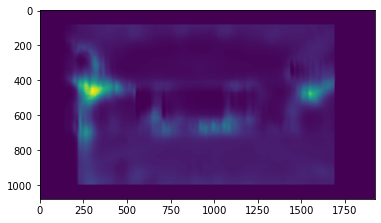

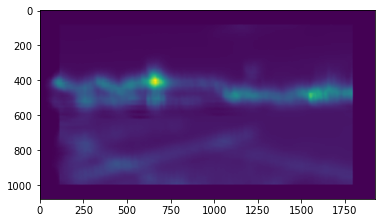

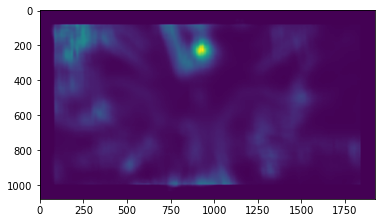

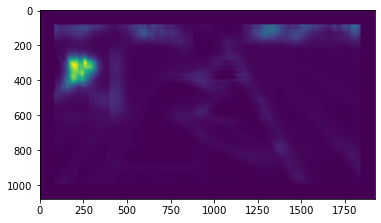

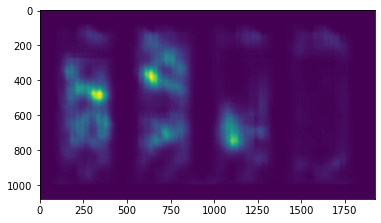

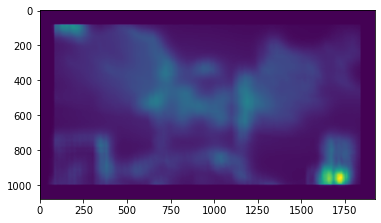

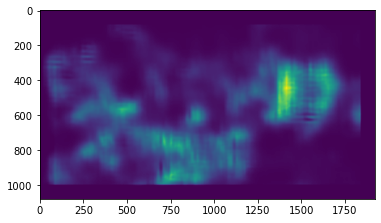

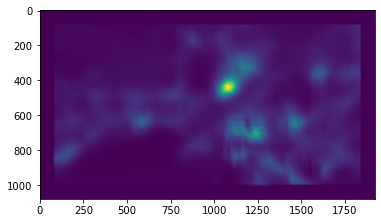

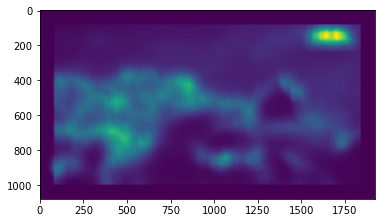

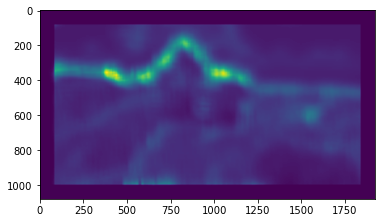

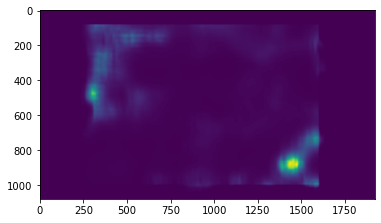

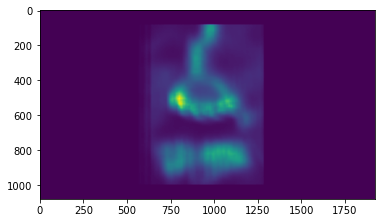

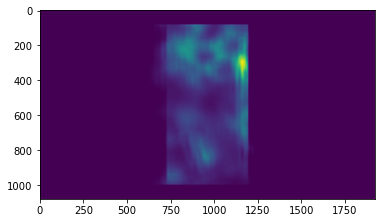

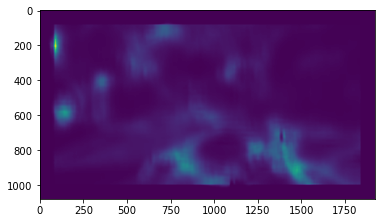

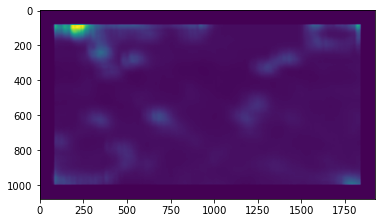

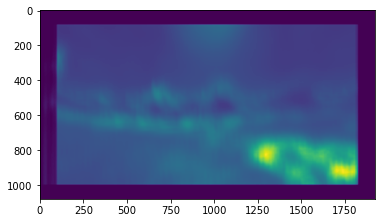

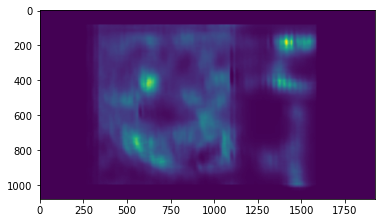

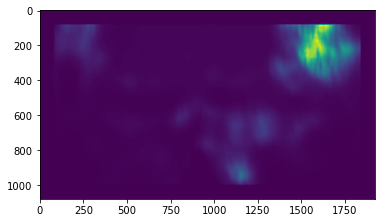

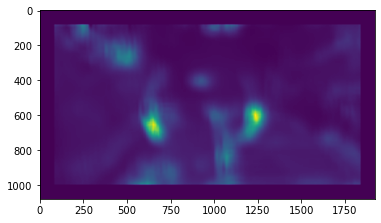

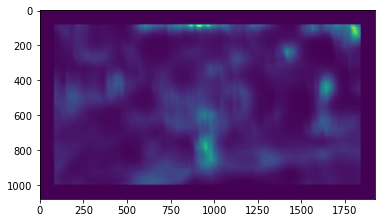

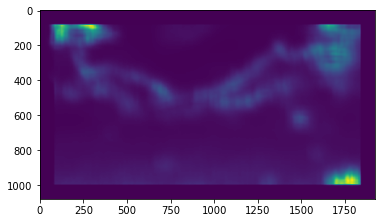

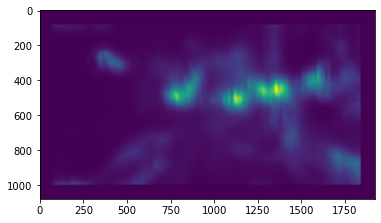

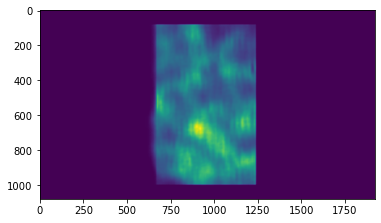

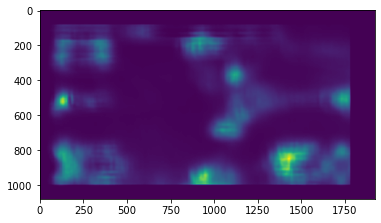

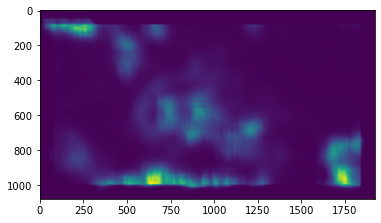

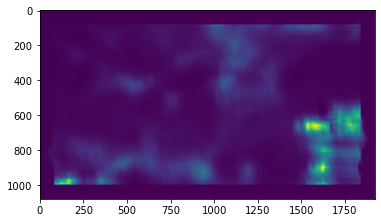

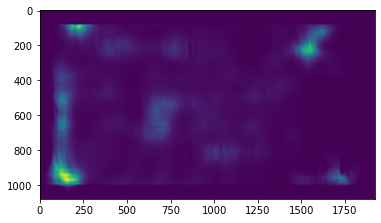

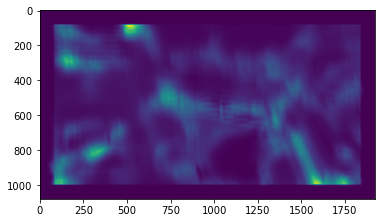

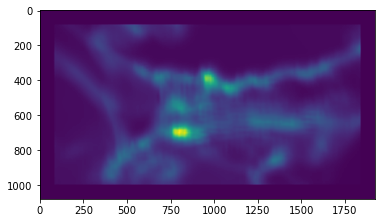

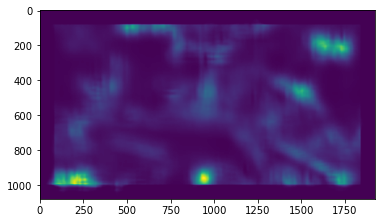

In [115]:
from tensorflow.keras.utils import array_to_img

y_pred = model.predict(x_test)

# save predicted imgs
i = 0
for inst in y_pred:    
    heat = (inst / np.max(inst)) ** 5 * 255
    heat = np.floor(heat).astype(int)
    img = array_to_img(heat).resize((1920, 1080))
    img.save('data/result/' + str(i) + '.png')
    i += 1
    
    fig, ax = plt.subplots()
    ax.imshow(img)

In [108]:
i = 3
true = y_test[i]
pred = y_pred[i]
# min-max normalization and enhance
pred = (pred / np.max(pred)) ** 5

l2 = np.linalg.norm(pred-true)
l2

21.12131

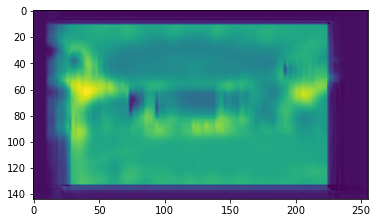

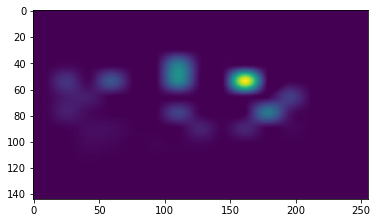

In [109]:
fig, ax = plt.subplots()
ax.imshow(y_pred[0])
fig, ax = plt.subplots()
ax.imshow(y_test[0])

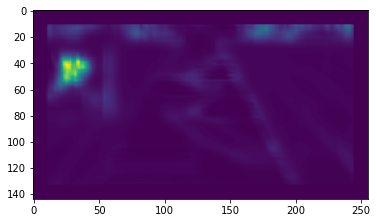

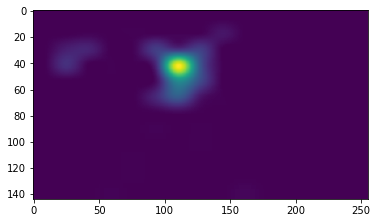

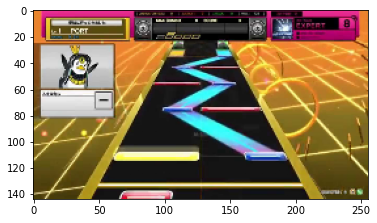

In [111]:
fig, ax = plt.subplots()
ax.imshow(pred)
fig, ax = plt.subplots()
ax.imshow(true)
fig, ax = plt.subplots()
ax.imshow(x_test[i])

In [94]:
np.max(pred)

1.0

In [103]:
for inst in y_pred:
    m = np.max(inst)
    if m != 1:
        print(m)

0.112031646
0.12062791
0.14575508
0.12556294
0.07594118
0.13373628
0.118896164
0.099994816
0.09884299
0.16400573
0.089482374
0.123721905
0.12309283
0.1258028
0.078704745
0.1533302
0.13765408
0.093472995
0.13384971
0.119698726
0.112060644
0.15128031
0.1259077
0.11146795
0.1399281
0.14989835
0.11328774
0.09585097
0.120549254
